In [100]:
BENCHMARK_TOOL = 'NVPROF' # or 'NCU'

import subprocess
import numpy as np
import pandas as pd
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter, FuncFormatter
from matplotlib import cm 

In [101]:
KERNELS = [
    "rgb2hsv", 
    "rgb2hsv_MinimuDivergence",
    "rgb2hsv_CoordinatedOutputs",
    "histogram",
    "histogram_WithSharedMemory",
    "histogram_WithSharedMemoryAndHardcodedSize",
    "histogram_WithMinilmumCalculationDepencies",
    "repart",
    "repart_WithSharedMemory",
    "repart_WithSharedMemoryAndHardcodedSize",
    "equalization",
    "equalization_ConstantCoefficient",
    "hsv2rgb",
    "hsv2rgb_MinimuDivergence"
]

In [102]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame, kernelNum=0) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        # conversion en ms 
        if df.loc[0, 'Duration'] == "ms":
            return float(df.loc[kernelNum + 1, 'Duration']) 
        if df.loc[0, 'Duration'] == "s":
            return float(df.loc[kernelNum + 1, 'Duration']) * 1e3
        # probablement en micro seconde
        return float(df.loc[kernelNum + 1, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [103]:
# Renvoie les durée moyennes en fonction de variation de tailles de l'axe X des blocs pour un certain kernel
def evaluateBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
    avg = 0
    xBlockSize, yBlockSize = 1, 1
    
    while xBlockSize <= 1024:
        for _ in range(nTry) :         
            avg += get_kernel_duration(read_benchmark(
                benchmark_kernel("./hist", 
                    "-f", "./img/chateau.png", 
                    "-b", str(kernelType), 
                    "-d", str(xBlockSize), str(yBlockSize)
                )
            ), kernelType)

        avg /= nTry
        durations.append(avg)    
        sizes.append(xBlockSize)
        xBlockSize *= 2
    return durations, sizes

In [104]:
def showHistogramDuration(durations, sizes, title, xLabel, yLabel):
    plt.title(title)  
    plt.xlabel(xLabel) 
    plt.ylabel(yLabel) 
    plt.bar(np.array(sizes).astype(str), np.array(durations), width=.8) 
    plt.show()

def showHistogramOfKernels(kernels, nTry = 10):  
    i = 0
    for k in kernels: 
        durations, sizes = evaluateBlocSize(i, nTry)
        showHistogramDuration(durations, sizes, k, "taille de bloc", "ms") 
        i+=1
 
print("Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X") 
#showHistogramOfKernels(KERNELS, 5)

Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X


In [105]:
def evaluate2DBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = [] 
    xBlockSize = 1
    step = 64

    while xBlockSize <= 1024:
        yBlockSize = 1
        durations.append([])
        while yBlockSize <= 1024:
            if (xBlockSize * yBlockSize) > 1024:
                durations[-1].append(np.nan)    
                #yBlockSize += step
                yBlockSize *= 2
                continue
            
            avg = 0 
            for _ in range(nTry) :         
                avg += get_kernel_duration(read_benchmark(
                    benchmark_kernel("./hist", 
                        "-f", "./img/chateau.png", 
                        "-b", str(kernelType), 
                        "-d", str(xBlockSize), str(yBlockSize)
                    )
                ), kernelType)

            avg /= nTry
            durations[-1].append(avg)   
            #yBlockSize += step if yBlockSize != 1 else -1
            yBlockSize *= 2
        sizes.append(xBlockSize)
         
        #xBlockSize += step if xBlockSize != 1 else -1
        xBlockSize *= 2
    return durations, sizes
 

In [106]:
print("Variation de la taille des blocs rgb to hsv")
durations, sizes = evaluate2DBlocSize(0, 1)   
print(durations)
print(sizes)

Variation de la taille des blocs rgb to hsv
[[0.156415, 0.15811, 0.158335, 0.158496, 0.158751, 0.158431, 0.158208, 0.157438, 0.157855, 0.157407, 0.155167], [0.181503, 0.158752, 0.158399, 0.155359, 0.157183, 0.160927, 0.180319, 0.154751, 0.158528, 0.182303, nan], [0.157215, 0.182015, 0.158688, 0.157247, 0.157568, 0.162816, 0.157983, 0.155871, 0.15888, nan, nan], [0.170527, 0.159263, 0.158592, 0.157279, 0.158911, 0.157823, 0.157631, 0.158719, nan, nan, nan], [0.163424, 0.157632, 0.157887, 0.156895, 0.17651, 0.159231, 0.160831, nan, nan, nan, nan], [0.156735, 0.161824, 0.155616, 0.159616, 0.154784, 0.156639, nan, nan, nan, nan, nan], [0.157759, 0.157504, 0.179999, 0.158528, 0.157375, nan, nan, nan, nan, nan, nan], [0.162751, 0.161919, 0.159839, 0.157504, nan, nan, nan, nan, nan, nan, nan], [0.16528, 0.162752, 0.156191, nan, nan, nan, nan, nan, nan, nan, nan], [0.183294, 0.159583, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.160223, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]
[1

In [119]:
"""
def showHistogramDuration3D_1(durations, sizesX, sizesY, xLabel, yLabel): 
    # get colormap
    ncolors = 256
    color_array = plt.get_cmap('spring')(range(ncolors))

    # change alpha values
    color_array[:,-1] = [0.5] * 256

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='my_color',colors=color_array)

    # register this new colormap with matplotlib
    plt.register_cmap(cmap=map_object)

    fig = plt.figure()
    ax.set_title("test")
    ax = fig.add_subplot(projection='3d') 
    X, Y = np.meshgrid(sizesX, sizesY)   
    surf = ax.plot_surface(X, Y, np.array(durations), rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False, vmin=0, vmax=10)

    
    # Customize the z axis.  
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))
    
    ax.legend() 
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel) 
    ax.set_zlabel("durée (en ms)")
 
    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1) 
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
def showHistogramDuration3D_2(durations, sizesX, sizesY, xLabel, yLabel): 
    # get colormap
    ncolors = 256
    color_array = plt.get_cmap('spring')(range(ncolors))

    # change alpha values
    color_array[:,-1] = [0.5] * 256

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='my_color',colors=color_array)

    # register this new colormap with matplotlib
    plt.register_cmap(cmap=map_object)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d') 
    X, Y = np.meshgrid(sizesX, sizesY)  

    dx = dy = 0.5 * np.ones_like(durations)
    dz = hist.ravel() 
    ax.bar3d(X.ravel(), Y.ravel(), durations, xLabel, dy, dz, zsort='average')
     
    
    # Customize the z axis.  
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))
    
    ax.legend() 
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel) 
    ax.set_zlabel("durée (en ms)")
 
    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1)  
    plt.show()
"""

def getBestParameters(durations, sizesX, sizesY):
    m = durations[0][0]
    x = 1
    y = 1

    for i in range(len(durations)):
        for j in range(len(durations[i])):  
            if (durations[i][j] < m and durations[i][j] != np.nan):
                m = durations[i][j]
                x = sizesX[i] 
                y = sizesY[j] 

    return m, x, y 

def log_tick_formatter(val, pos=None): 
    return int(10**val)
    #return "{:.2e}".format(10**val)
    #return r"$10^{{{:.0f}}}$".format(val)

def showHistogramDuration3DHist(durations, sizesX, sizesY, title, xLabel, yLabel): 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Temps d'éxecution du kernel: " + title)
 
    xpos, ypos = np.meshgrid(sizesX, sizesY)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F') 
    dz = np.array(durations).flatten() 
    minZ, maxZ = min(dz), max(dz)
    zpos = np.full_like(dz, minZ /2, dtype=np.double)   
     
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()  
    cmap = cm.get_cmap('jet')
    rgb = [cmap((k-minZ)/ (maxZ-minZ)) for k in dz] 
    hist = ax.bar3d(np.log10(xpos), np.log10(ypos), zpos, 0.1, 0.1, dz, color=rgb, alpha=0.2, zsort='average')

    # Customize the z axis.  
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))

    ax.xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter)) 
  
    ax.set_zlim(minZ /2, maxZ * 2)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel) 
    ax.set_zlabel("durée (en ms)")  
    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1) 
    fig.colorbar(hist)
    d, x, y  = getBestParameters(durations, sizesX, sizesY) 
    plt.figtext(0.53, -0.03, "Meilleur temps: " + str(minZ) + " ms\navec " + xLabel + " : " + str(x) + "\n    et" + yLabel + " : " + str(y) , ha="center", bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.show()

  

In [108]:
 

def testBlocKernels(kernels, nTry = 1):
    for i in range(len(kernels)):
        print("Execution du kernel : ", kernels[i], "avec ", nTry, " essaie.")

        durations, sizes = evaluate2DBlocSize(0, nTry)   
        showHistogramDuration3DHist(durations, sizes, sizes, kernels[i], "taille de bloc x", "taille de bloc y") 
 
 

No handles with labels found to put in legend.


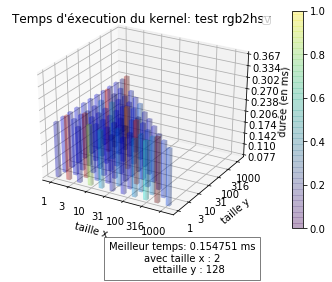

In [120]:
getBestParameters(durations, sizes, sizes)    
showHistogramDuration3DHist(durations, sizes, sizes, "test rgb2hsv", "taille x", "taille y")

Execution du kernel :  rgb2hsv avec  10  essaie.


No handles with labels found to put in legend.


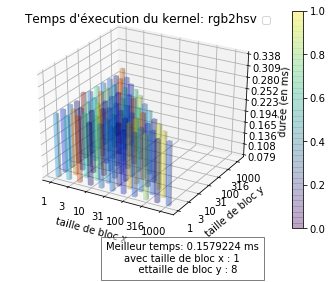

Execution du kernel :  rgb2hsv_MinimuDivergence avec  10  essaie.


No handles with labels found to put in legend.


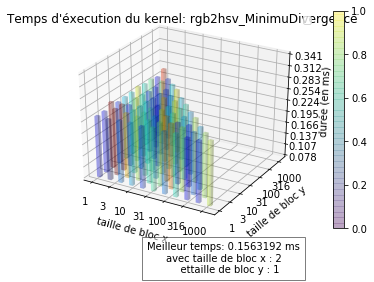

Execution du kernel :  rgb2hsv_CoordinatedOutputs avec  10  essaie.


In [121]:
testBlocKernels(KERNELS, 10)